# Введение в искусственные нейронные сети
# Урок 8. GAN

## Задание 1
1.	Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшении работы нейронной сети.

* вариант для 1) Обучите VAE на fashion_mnist


## Решение базовое
* модель Variational AutoEncoder (VAE)
* слои энкодера Conv2D 32 > Conv2D 64 > > Flatten > Dense 16
* слои декодера Dense 64 > Reshape 64 > Conv2DT 64 > Conv2DT 32 > Conv2DT 1
* оптимизатор Adam
* 30 эпох


### Setup


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


### Строим слой семплирования sampling layer


In [2]:
# стороим кастомный слой 
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a unit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs  # с двумя параметрами на входе
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1] # определяем размер нашего пространства
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # строим шум
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # восстанавливаем пакет единиц информации, опираясь на параметры нашего распределения



### Строим энкодер encoder


In [3]:
latent_dim = 2 # берем пространство равное 2 для быстроты

encoder_inputs = keras.Input(shape=(28, 28, 1))
# строим сверточную модель
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
# строим выходы
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
# получилась модель: на входе картинка, на выходе 3 тензора
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

### Строим свой decoder


In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
# размерность 7 * 7 * 64 позволяет потом построить выход 28
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# превращаем в тензор более сложной формы 4-мерный
x = layers.Reshape((7, 7, 64))(x)
# как тольо сказали strides=2, то увеличили ращмерность в 2 раза
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x) # 14x14
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x) # 28x28
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x) # одноканальная картинка 28x28
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

### Создаем класс модель по `Model` с особым шагом *обучения* `train_step`


In [5]:
# создаем модель как наследник класса Model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data): # меняем на свое обучение функцию train_step
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape: # создаем объект для дифферецнирования
            z_mean, z_log_var, z = encoder(data)  # картинки пропускаем через энкодер
            reconstruction = decoder(z) # пропускаем через декодер
            # строим первый loss
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            # строим второй loss
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5 # коэффициент обеспечивает равный вклад двух лоссов
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights) # говорим, что у модели будут тренироваться веса
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }



### Учим VAE


In [6]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data() # подгружаем FASHION-MNIST
mnist_units = np.concatenate([x_train, x_test], axis=0)
mnist_units = np.expand_dims(mnist_units, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam()) # задаем оптимайзер
vae.fit(mnist_units, epochs=30, batch_size=128) # проводим обучение


4423680/4422102 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 71s 127ms/step - loss: 320.1489 - reconstruction_loss: 316.3461 - kl_loss: 3.8028
Epoch 2/30
547/547 [==============================] - 70s 127ms/step - loss: 270.9996 - reconstruction_loss: 267.5391 - kl_loss: 3.4604
Epoch 3/30
547/547 [==============================] - 69s 126ms/step - loss: 267.2896 - reconstruction_loss: 263.8422 - kl_loss: 3.4474
Epoch 4/30
547/547 [==============================] - 69s 127ms/step - loss: 265.3497 - reconstruction_loss: 261.9012 - kl_loss: 3.4485
Epoch 5/30
547/547 [==============================] - 69s 126ms/step - loss: 264.0282 - reconstruction_loss: 260.5636 - kl_loss: 3.4646
Epoch 6/30
547/547 [==============================] - 69s 126ms/step - loss: 263.1222 - reconstruction_loss: 259.6435 - kl_loss: 3.4787
Epoch 7/30
547/547 [==============================] - 69s 126ms/step - loss: 262.3383 - reconstruction_loss: 258.8425 - k

### Результат предсказания для одежды


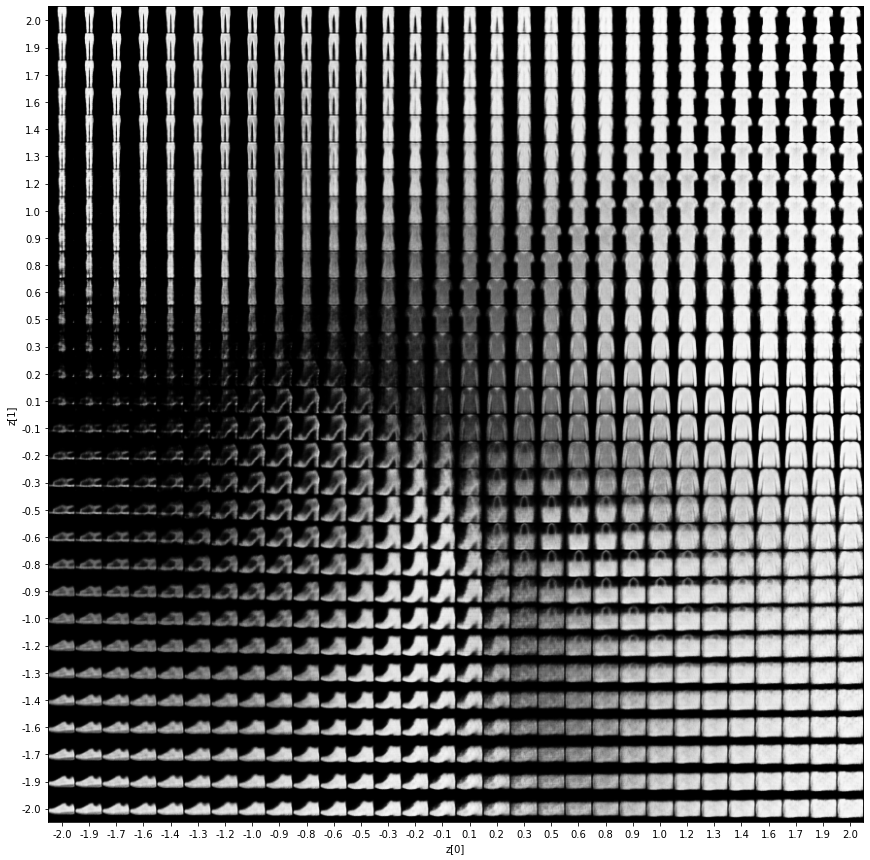

In [7]:
import matplotlib.pyplot as plt

# на этапе предсказания энкодер не нужен
# По одной точке из скрытого пространства восстанавливаем объект, подавая через декодер
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of units
    n = 30
    unit_size = 28
    scale = 2.0 # диапазон пространства от минус 2 до 2
    figsize = 15
    figure = np.zeros((unit_size * n, unit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of unit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            unit = x_decoded[0].reshape(unit_size, unit_size)
            figure[
                i * unit_size : (i + 1) * unit_size,
                j * unit_size : (j + 1) * unit_size,
            ] = unit

    plt.figure(figsize=(figsize, figsize))
    start_range = unit_size // 2
    end_range = n * unit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, unit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)


### Посмотрим на кластеры в скрытом пространстве для одежды


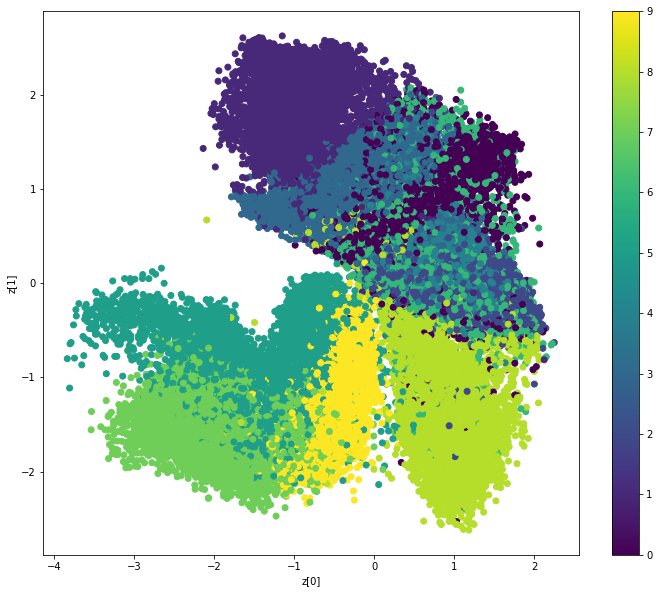

In [8]:

def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the unit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)


Построим немного примеров генерации одежды:

для этого не нужен энкодер
работа этой модели требует:
- выбрать случайные значения для точки скрытого пространства (2 координаты (среднее и логарифм от дисперсиии) - для построения в n (в нашем случае 28х28) координаты нового образца )
- подать их в декодер
- визуализировать результат

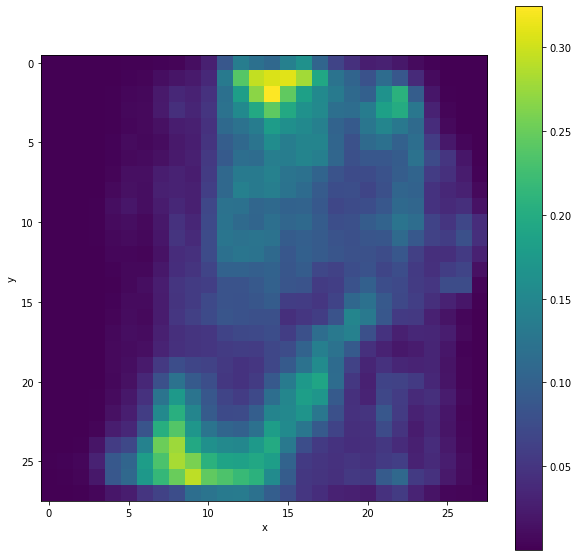

In [9]:

def plot_unit_from_decoder(decoder, z, unit_size):
    # display a 2D plot of the unit classes in the latent space
    
    data = np.array([[z[0], z[1]]])
    unit = decoder.predict(data)
    unit = unit.reshape(unit_size, unit_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(unit)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()



plot_unit_from_decoder(decoder, [-0.5,0.2], 28)